# Projet : Classification des émotions avec CNN (Dataset FER)
---

## Introduction
Ce projet vise à développer un modèle de reconnaissance des émotions à partir du dataset FER. L'objectif est de prédire l'émotion représentée dans une image à l'aide de trois approches : 
1. **Un modèle CNN personnalisé**,
2. **Le transfert learning**,
3. **Le fine-tuning**.  

Ce document se concentre sur la première approche (**CNN personnalisé**) avec des étapes claires, des visualisations et une analyse approfondie.

---

## Structure générale du projet
1. **Analyse exploratoire des données**  
   Comprendre la structure et la distribution des données, notamment les classes et leur répartition.
2. **Prétraitement des données**  
   Préparer les images via des transformations adaptées (augmentation et normalisation).
3. **Construction du modèle CNN**  
   Définir un modèle simple mais efficace pour extraire les caractéristiques et prédire les émotions.
4. **Entraînement et validation**  
   Former le modèle, suivre les métriques (perte et précision) et évaluer la performance.
5. **Visualisations et analyses des résultats**  
   Comprendre les performances du modèle avec des courbes de perte, de précision, et une matrice de confusion.
   


## 1 - Prétraitement des données

### Objectif
Préparer les images pour qu'elles soient compatibles avec le modèle, tout en améliorant la robustesse via des augmentations de données.

### Étapes
1. **Redimensionner les images** à une taille uniforme (48x48).  
   Cela simplifie le traitement et réduit la mémoire nécessaire.
2. **Appliquer des augmentations** pour les données d'entraînement :  
   - Flips horizontaux aléatoires,
   - Rotations aléatoires,
   - Normalisation pour standardiser les pixels.
3. **Normalisation** sur l'ensemble des données (train et validation) avec des moyennes et écarts-types spécifiques.

### Visualisation
Affiche un échantillon d'images augmentées pour vérifier visuellement que les transformations fonctionnent comme prévu.

In [20]:
# Importation des librairies nécessaires pour effectuer le travail
import os
import torch
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from tqdm import tqdm

In [21]:
# Vérification de l'appareil GPU/CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device utilisé : {device}")

Device utilisé : cpu


In [22]:
def visualize_dataset_structure(dataset_path):
    """
    Affiche la structure du dataset en comptant les images dans chaque classe.
    """
    class_counts = {}
    for root, dirs, files in os.walk(dataset_path):
        if len(files) > 0:
            class_name = os.path.basename(root)
            class_counts[class_name] = len(files)

    # Visualisation des données par classe
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Nombre d\'images')
    plt.title('Distribution des données dans le dataset')
    plt.xticks(rotation=45)
    plt.show()

Structure des données dans le dossier Train :


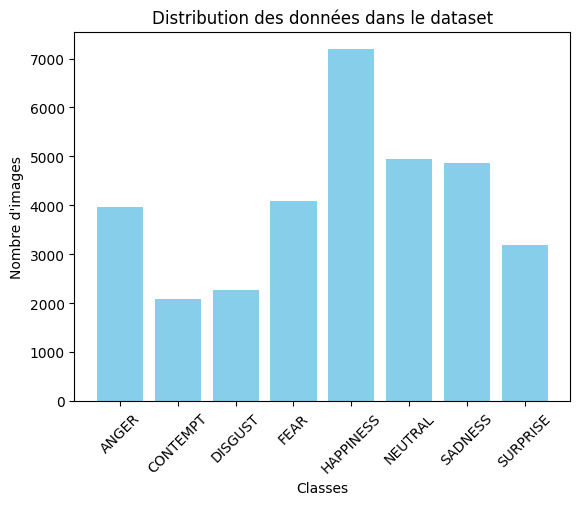

Structure des données dans le dossier Validation :


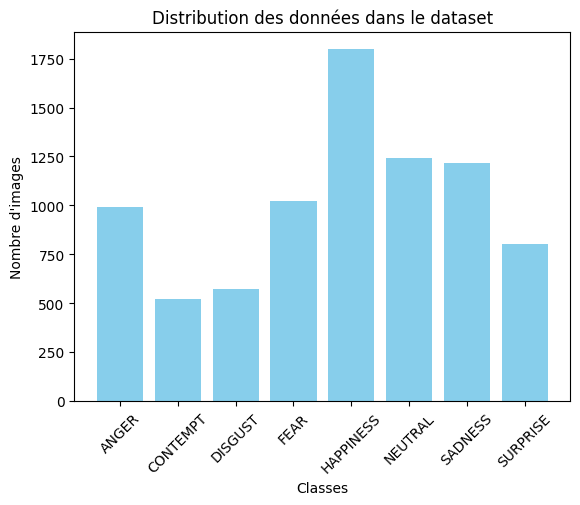

In [23]:
# Chemin vers le dataset
dataset_path_train = "D:\\Projets\\Projets personnels\\CNN_Sentiment_Viz\\FERPlus-master-images\\train"
dataset_path_val = "D:\\Projets\\Projets personnels\\CNN_Sentiment_Viz\\FERPlus-master-images\\val"

print("Structure des données dans le dossier Train :")
visualize_dataset_structure(dataset_path_train)

print("Structure des données dans le dossier Validation :")
visualize_dataset_structure(dataset_path_val)

In [24]:
# Transformations améliorées pour l'entraînement
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomResizedCrop(48, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Transformations pour la validation
transform_val = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(48),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [25]:
# Transformation pour les images en niveaux de gris
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [26]:
# Chargement des datasets
train_dataset = datasets.ImageFolder(root=dataset_path_train, transform=transform)
val_dataset = datasets.ImageFolder(root=dataset_path_val, transform=transform)

In [27]:
# Configuration des hyperparamètres
BATCH_SIZE = 32  # Réduit pour une meilleure généralisation
NUM_EPOCHS = 50  # Plus d'époques avec early stopping
LEARNING_RATE = 0.001

# Création des DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [28]:
# Affichage des classes
classes = train_dataset.classes
print(f"Classes du dataset : {classes}")

Classes du dataset : ['ANGER', 'CONTEMPT', 'DISGUST', 'FEAR', 'HAPPINESS', 'NEUTRAL', 'SADNESS', 'SURPRISE']


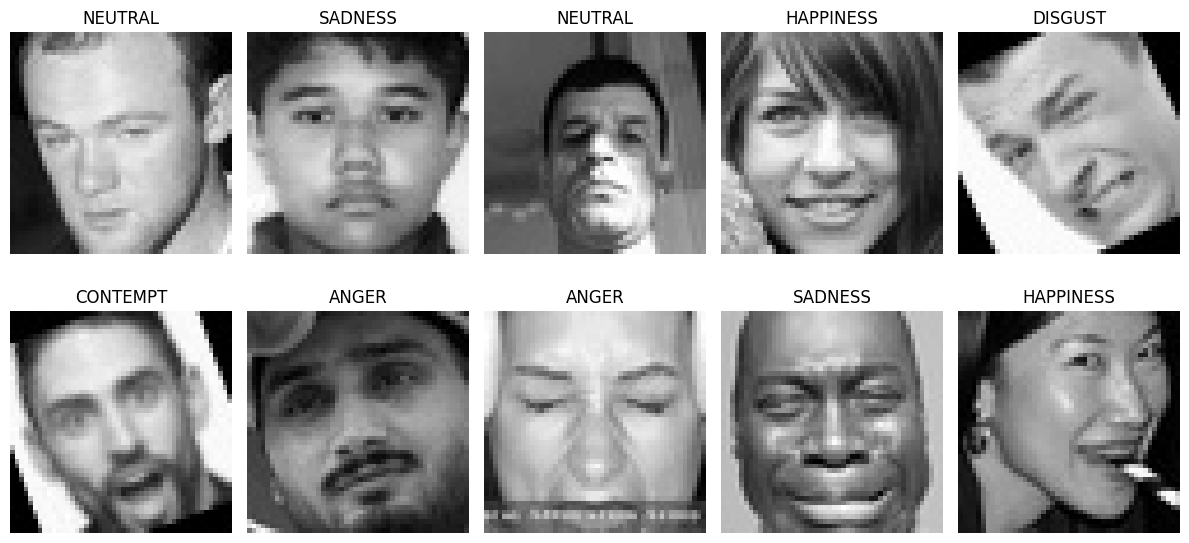

In [29]:
def visualize_augmented_samples(data_loader, classes):
    """
    Visualiser 10 exemples d'images augmentées avec leurs étiquettes.

    Arguments:
    - data_loader : DataLoader pour les données.
    - classes : Liste des noms des classes.
    """
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    # Définir une figure pour afficher 10 images
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    for i in range(10):
        ax = axes[i // 5, i % 5]
        image = images[i].permute(1, 2, 0)  
        image = image.numpy()

        if image.shape[2] == 1: 
            ax.imshow(image.squeeze(), cmap='gray')
        else: 
            ax.imshow(image)

        ax.set_title(classes[labels[i].item()])
        ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_augmented_samples(train_loader, classes)

## Construction du modèle CNN

### Objectif
Développer un modèle CNN pour extraire des caractéristiques visuelles et effectuer une classification.

### Architecture proposée
1. **Convolutions et pooling** : Trois couches de convolutions suivies de pooling pour extraire des caractéristiques importantes.  
2. **Couches entièrement connectées (FC)** : Transforme les caractéristiques extraites en prédictions.  
3. **Dropout** : Réduit le surapprentissage en rendant le modèle plus général.


In [30]:
class EmotionCNN(nn.Module):
    """
    Modèle CNN amélioré pour la classification des émotions.
    """
    def __init__(self):
        super(EmotionCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # Premier bloc
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25),
            
            # Deuxième bloc
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25),
            
            # Troisième bloc
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 6 * 6, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, len(classes))
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

# Instanciation du modèle
model = EmotionCNN().to(device)

## Entraînement et validation

### Objectif
Former le modèle sur les données d'entraînement et évaluer ses performances sur les données de validation.

### Étapes
1. **Définir une fonction de perte** : Utiliser l'entropie croisée (CrossEntropyLoss) adaptée pour la classification multi-classes.
2. **Choisir un optimiseur** : Adam est utilisé pour sa rapidité et sa gestion adaptative du taux d'apprentissage.
3. **Boucle d'entraînement** :  
   - Forward pass (prédiction),
   - Calcul de la perte,
   - Backward pass (propagation du gradient),
   - Mise à jour des poids.
4. **Boucle de validation** :  
   - Désactive le calcul des gradients (pour économiser de la mémoire),
   - Évalue le modèle sur les données de validation.

### Suivi des performances
1. Affiche les pertes (train/val) à chaque epoch.  
2. Calcule la précision sur les données de validation.


In [31]:
# Early Stopping
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
        elif val_loss > self.best_loss + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
            self.counter = 0

# Configuration de l'entraînement
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=LEARNING_RATE,
    epochs=NUM_EPOCHS,
    steps_per_epoch=len(train_loader)
)

# Fonction d'entraînement
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs):
    """
    Entraîne le modèle avec early stopping et learning rate scheduling.
    
    Args :
    - model : le modèle PyTorch à entraîner
    - train_loader : DataLoader pour les données d'entraînement
    - val_loader : DataLoader pour les données de validation
    - criterion : fonction de perte
    - optimizer : optimiseur
    - scheduler : scheduler pour le learning rate
    - epochs : nombre d'époques maximum

    Returns :
    - train_losses : liste des pertes d'entraînement par époque
    - val_losses : liste des pertes de validation par époque
    - val_accuracies : liste des précisions sur le jeu de validation par époque
    """
    train_losses = []
    val_losses = []
    val_accuracies = []
    early_stopping = EarlyStopping(patience=5)

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # Phase d'entraînement
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        print(f"Training Loss: {epoch_loss:.4f}")

        # Phase de validation
        model.eval()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}"):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                correct_predictions += (preds == labels).sum().item()
                total_predictions += labels.size(0)

        val_loss = running_loss / len(val_loader.dataset)
        val_accuracy = correct_predictions / total_predictions

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.2%}")

        # Early Stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            model.load_state_dict(early_stopping.best_model)
            break

    return train_losses, val_losses, val_accuracies


In [32]:
# Entraînement du modèle
train_losses, val_losses, val_accuracies = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    NUM_EPOCHS
)

Epoch 1/50


Training Epoch 1: 100%|██████████| 1021/1021 [09:49<00:00,  1.73it/s]


Training Loss: 1.8717


Validation Epoch 1: 100%|██████████| 256/256 [01:38<00:00,  2.60it/s]


Validation Loss: 1.6381 | Validation Accuracy: 35.48%
Epoch 2/50


Training Epoch 2: 100%|██████████| 1021/1021 [03:08<00:00,  5.42it/s]


Training Loss: 1.6274


Validation Epoch 2: 100%|██████████| 256/256 [00:16<00:00, 15.42it/s]


Validation Loss: 1.4390 | Validation Accuracy: 43.88%
Epoch 3/50


Training Epoch 3: 100%|██████████| 1021/1021 [03:06<00:00,  5.46it/s]


Training Loss: 1.5051


Validation Epoch 3: 100%|██████████| 256/256 [00:16<00:00, 15.64it/s]


Validation Loss: 1.3587 | Validation Accuracy: 46.09%
Epoch 4/50


Training Epoch 4: 100%|██████████| 1021/1021 [03:02<00:00,  5.59it/s]


Training Loss: 1.4354


Validation Epoch 4: 100%|██████████| 256/256 [00:17<00:00, 14.40it/s]


Validation Loss: 1.3065 | Validation Accuracy: 49.68%
Epoch 5/50


Training Epoch 5: 100%|██████████| 1021/1021 [03:12<00:00,  5.29it/s]


Training Loss: 1.3681


Validation Epoch 5: 100%|██████████| 256/256 [00:18<00:00, 13.96it/s]


Validation Loss: 1.2497 | Validation Accuracy: 51.21%
Epoch 6/50


Training Epoch 6: 100%|██████████| 1021/1021 [03:11<00:00,  5.34it/s]


Training Loss: 1.3187


Validation Epoch 6: 100%|██████████| 256/256 [00:16<00:00, 15.17it/s]


Validation Loss: 1.1815 | Validation Accuracy: 54.52%
Epoch 7/50


Training Epoch 7: 100%|██████████| 1021/1021 [03:04<00:00,  5.54it/s]


Training Loss: 1.2924


Validation Epoch 7: 100%|██████████| 256/256 [00:16<00:00, 15.55it/s]


Validation Loss: 1.1643 | Validation Accuracy: 54.41%
Epoch 8/50


Training Epoch 8: 100%|██████████| 1021/1021 [03:00<00:00,  5.65it/s]


Training Loss: 1.2571


Validation Epoch 8: 100%|██████████| 256/256 [00:16<00:00, 15.60it/s]


Validation Loss: 1.1433 | Validation Accuracy: 55.11%
Epoch 9/50


Training Epoch 9: 100%|██████████| 1021/1021 [03:01<00:00,  5.61it/s]


Training Loss: 1.2373


Validation Epoch 9: 100%|██████████| 256/256 [00:16<00:00, 15.51it/s]


Validation Loss: 1.1136 | Validation Accuracy: 57.94%
Epoch 10/50


Training Epoch 10: 100%|██████████| 1021/1021 [03:01<00:00,  5.62it/s]


Training Loss: 1.2126


Validation Epoch 10: 100%|██████████| 256/256 [00:16<00:00, 15.19it/s]


Validation Loss: 1.1229 | Validation Accuracy: 56.60%
Epoch 11/50


Training Epoch 11: 100%|██████████| 1021/1021 [02:57<00:00,  5.74it/s]


Training Loss: 1.1835


Validation Epoch 11: 100%|██████████| 256/256 [00:16<00:00, 15.16it/s]


Validation Loss: 1.1170 | Validation Accuracy: 55.99%
Epoch 12/50


Training Epoch 12: 100%|██████████| 1021/1021 [03:01<00:00,  5.63it/s]


Training Loss: 1.1445


Validation Epoch 12: 100%|██████████| 256/256 [00:17<00:00, 15.00it/s]


Validation Loss: 1.0624 | Validation Accuracy: 59.56%
Epoch 13/50


Training Epoch 13: 100%|██████████| 1021/1021 [02:25<00:00,  7.01it/s]


Training Loss: 1.1096


Validation Epoch 13: 100%|██████████| 256/256 [00:12<00:00, 20.65it/s]


Validation Loss: 1.0529 | Validation Accuracy: 60.04%
Epoch 14/50


Training Epoch 14: 100%|██████████| 1021/1021 [02:19<00:00,  7.34it/s]


Training Loss: 1.0768


Validation Epoch 14: 100%|██████████| 256/256 [00:12<00:00, 20.53it/s]


Validation Loss: 1.0201 | Validation Accuracy: 60.90%
Epoch 15/50


Training Epoch 15: 100%|██████████| 1021/1021 [02:19<00:00,  7.30it/s]


Training Loss: 1.0404


Validation Epoch 15: 100%|██████████| 256/256 [00:12<00:00, 20.91it/s]


Validation Loss: 1.0018 | Validation Accuracy: 61.65%
Epoch 16/50


Training Epoch 16: 100%|██████████| 1021/1021 [02:17<00:00,  7.43it/s]


Training Loss: 1.0083


Validation Epoch 16: 100%|██████████| 256/256 [00:12<00:00, 19.88it/s]


Validation Loss: 1.0008 | Validation Accuracy: 62.36%
Epoch 17/50


Training Epoch 17: 100%|██████████| 1021/1021 [02:20<00:00,  7.24it/s]


Training Loss: 0.9735


Validation Epoch 17: 100%|██████████| 256/256 [00:12<00:00, 20.42it/s]


Validation Loss: 0.9722 | Validation Accuracy: 63.30%
Epoch 18/50


Training Epoch 18: 100%|██████████| 1021/1021 [02:21<00:00,  7.23it/s]


Training Loss: 0.9431


Validation Epoch 18: 100%|██████████| 256/256 [00:12<00:00, 20.34it/s]


Validation Loss: 0.9737 | Validation Accuracy: 63.59%
Epoch 19/50


Training Epoch 19: 100%|██████████| 1021/1021 [02:21<00:00,  7.23it/s]


Training Loss: 0.9139


Validation Epoch 19: 100%|██████████| 256/256 [00:12<00:00, 20.32it/s]


Validation Loss: 0.9616 | Validation Accuracy: 64.18%
Epoch 20/50


Training Epoch 20: 100%|██████████| 1021/1021 [02:19<00:00,  7.31it/s]


Training Loss: 0.8746


Validation Epoch 20: 100%|██████████| 256/256 [00:12<00:00, 20.72it/s]


Validation Loss: 0.9637 | Validation Accuracy: 64.07%
Epoch 21/50


Training Epoch 21: 100%|██████████| 1021/1021 [02:19<00:00,  7.32it/s]


Training Loss: 0.8522


Validation Epoch 21: 100%|██████████| 256/256 [00:13<00:00, 19.15it/s]


Validation Loss: 0.9520 | Validation Accuracy: 64.61%
Epoch 22/50


Training Epoch 22: 100%|██████████| 1021/1021 [02:19<00:00,  7.31it/s]


Training Loss: 0.8187


Validation Epoch 22: 100%|██████████| 256/256 [00:12<00:00, 20.49it/s]


Validation Loss: 0.9516 | Validation Accuracy: 65.00%
Epoch 23/50


Training Epoch 23: 100%|██████████| 1021/1021 [02:19<00:00,  7.31it/s]


Training Loss: 0.7904


Validation Epoch 23: 100%|██████████| 256/256 [00:12<00:00, 20.29it/s]


Validation Loss: 0.9571 | Validation Accuracy: 65.25%
Epoch 24/50


Training Epoch 24: 100%|██████████| 1021/1021 [02:20<00:00,  7.28it/s]


Training Loss: 0.7558


Validation Epoch 24: 100%|██████████| 256/256 [00:12<00:00, 20.32it/s]


Validation Loss: 0.9731 | Validation Accuracy: 64.54%
Epoch 25/50


Training Epoch 25: 100%|██████████| 1021/1021 [02:19<00:00,  7.33it/s]


Training Loss: 0.7303


Validation Epoch 25: 100%|██████████| 256/256 [00:12<00:00, 20.59it/s]


Validation Loss: 0.9640 | Validation Accuracy: 65.82%
Epoch 26/50


Training Epoch 26: 100%|██████████| 1021/1021 [02:17<00:00,  7.41it/s]


Training Loss: 0.7102


Validation Epoch 26: 100%|██████████| 256/256 [00:12<00:00, 20.13it/s]


Validation Loss: 0.9583 | Validation Accuracy: 66.24%
Epoch 27/50


Training Epoch 27: 100%|██████████| 1021/1021 [02:21<00:00,  7.22it/s]


Training Loss: 0.6642


Validation Epoch 27: 100%|██████████| 256/256 [00:13<00:00, 19.61it/s]

Validation Loss: 0.9589 | Validation Accuracy: 65.67%
Early stopping triggered


## Visualisations et analyse des résultats

### Objectif
Interpréter les résultats pour comprendre les forces et faiblesses du modèle.

### Visualisations proposées
1. **Courbes de perte et de précision** :  
   - Suivi de l'évolution des pertes d'entraînement et de validation.
   - Précision globale sur les données de validation.
2. **Matrice de confusion** :  
   - Montre les prédictions correctes et incorrectes par classe.
   - Identifie les classes confondues pour guider les améliorations futures.



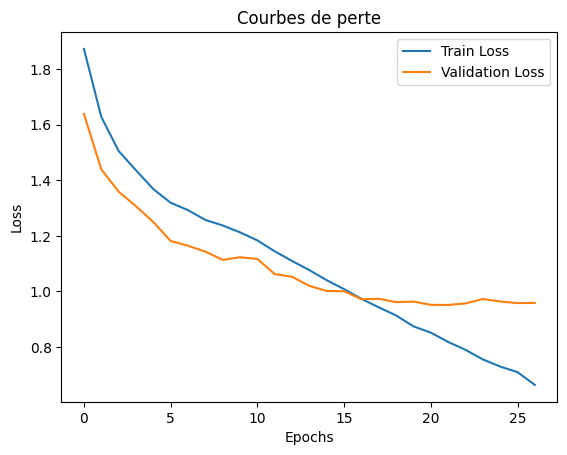

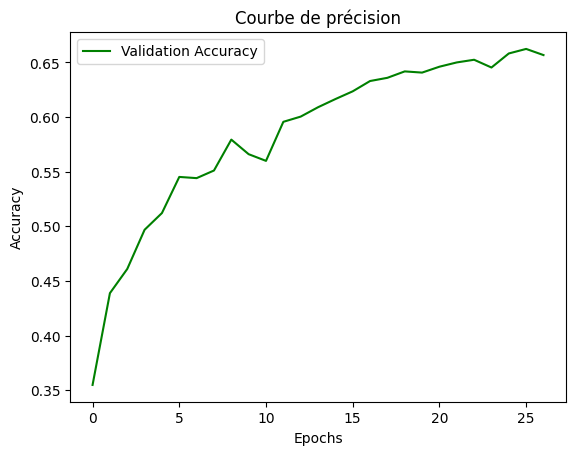

In [33]:
# Courbes de perte
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Courbes de perte')
plt.show()

# Courbes de précision
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Courbe de précision')
plt.show()

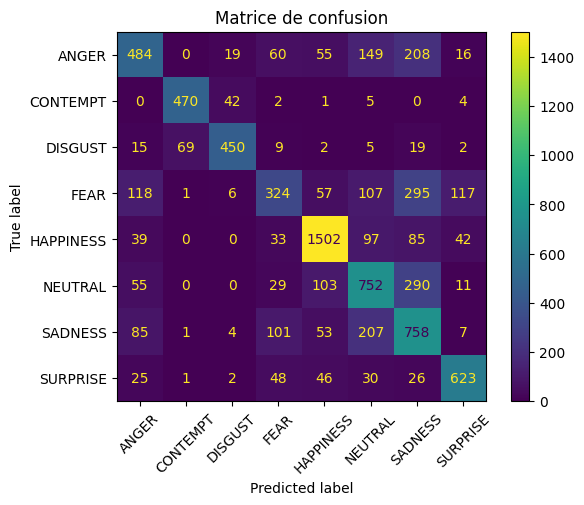

In [34]:
def plot_confusion_matrix(model, loader, classes):
    """
    Génère une matrice de confusion pour les données de validation.
    """
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap='viridis', xticks_rotation=45)
    plt.title('Matrice de confusion')
    plt.show()

plot_confusion_matrix(model, val_loader, classes)

In [35]:
# Chemin du dossier et nom du fichier
dossier_sauvegarde = "modele"
nom_fichier = "cnn_emotion_model.pth"

# Créer le dossier s'il n'existe pas
os.makedirs(dossier_sauvegarde, exist_ok=True)

# Chemin complet du fichier
chemin_complet = os.path.join(dossier_sauvegarde, nom_fichier)

# Sauvegarder le modèle
torch.save(model.state_dict(), chemin_complet)

print(f"Modèle sauvegardé dans : {chemin_complet}")

Modèle sauvegardé dans : modele\cnn_emotion_model.pth
